# Ingest

In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

In [2]:
# Ingest function
def get_iris():
    """
    This function loads the iris dataset from sklearn datasets
    """
    # Load dataset, get the featues and labels
    dataset = load_iris(as_frame=True)
    feature=dataset.data
    label=dataset.target

    # Merge the featues and labels into one dataframe
    df = feature.copy()
    df["species"] = label

    # Convert the target into acutal classes
    target = {
        0: "setosa",
        1: "versicolor",
        2: "virginica"
    }
    
    df['species'] = df["species"].map(target)

    rename_col = {
        "sepal length (cm)": "sepal_length",
        "sepal width (cm)": "sepal_width",
        "petal length (cm)": "petal_length",
        "petal width (cm)": "petal_width"
    }
    df = df.rename(columns=rename_col)
   
    return df

In [3]:
iris_df = get_iris()

In [4]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
# Transform the dataset into a more useable format

def split_and_transform_iris(df):
    df = df.copy()

    target = {
        "setosa": 0,
        "versicolor": 1,
        "virginica": 2
    }

    df["species"] = df['species'].map(target) 

    target_col = 'species'
    X, y = df.drop(columns=[target_col]), df[target_col]

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, shuffle=True, random_state=42, stratify=y)
    
    return X_train, y_train, X_test, y_test

In [6]:
X_train, y_train, X_test, y_test = split_and_transform_iris(iris_df)

In [7]:
X_train.head()

,sepal_length,sepal_width,petal_length,petal_width
98,5.1,2.5,3.0,1.1
68,6.2,2.2,4.5,1.5
19,5.1,3.8,1.5,0.3
143,6.8,3.2,5.9,2.3
99,5.7,2.8,4.1,1.3


In [8]:
X_test.head()

,sepal_length,sepal_width,petal_length,petal_width
107,7.3,2.9,6.3,1.8
63,6.1,2.9,4.7,1.4
133,6.3,2.8,5.1,1.5
56,6.3,3.3,4.7,1.6
127,6.1,3.0,4.9,1.8


In [9]:
y_train.head()

98     1
68     1
19     0
143    2
99     1
Name: species, dtype: int64

In [10]:
y_test.head()

107    2
63     1
133    2
56     1
127    2
Name: species, dtype: int64

# Preprocessing pipeline

In [11]:
feats = X_train.columns.to_list()
feats

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [12]:
preprocessing = make_pipeline(
    StandardScaler()
)

In [13]:
# Test the transformaton
X_train_transformed = preprocessing.fit_transform(X_train)
X_train_transformed[0]

array([-0.90045861, -1.22024754, -0.4419858 , -0.13661044])

# Modelling

### Ridge Classifier

In [14]:
ridge_clf = make_pipeline(
    preprocessing,
    RidgeClassifier(random_state=42)
)

In [15]:
ridge_clf.fit(X_train, y_train)
ridge_preds = ridge_clf.predict(X_train)

In [16]:
accuracy_score(y_train, ridge_preds)

0.8761904761904762

Evaluate it on the validation set

In [17]:
# Get out of sample predictions
ridge_val_preds = cross_val_predict(ridge_clf, X_train, y_train, cv=3)

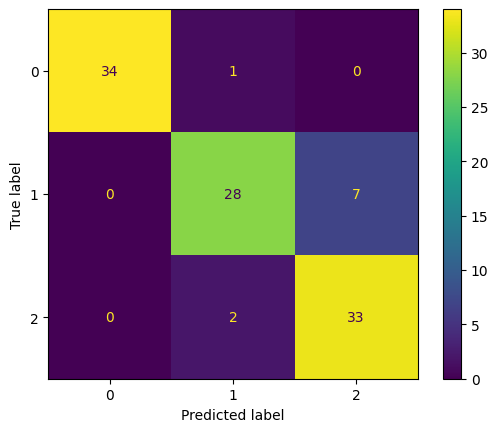

In [18]:
ConfusionMatrixDisplay.from_predictions(y_true=y_train, y_pred=ridge_val_preds)
plt.show()

The relationship between the variables are not really linear. This is expected

Lets try a more powerful model

### SVM

In [19]:
svc_clf = make_pipeline(
    preprocessing,
    SVC(random_state=42, kernel='rbf', probability=True, decision_function_shape='ovo')
)

In [20]:
# Crossvalidation score
svc_accs = cross_val_score(svc_clf, X_train, y_train,
                              scoring='accuracy', cv=3)

In [21]:
svc_accs

array([0.97142857, 0.94285714, 0.97142857])

In [22]:
pd.Series(svc_accs).describe()

count    3.000000
mean     0.961905
std      0.016496
min      0.942857
25%      0.957143
50%      0.971429
75%      0.971429
max      0.971429
dtype: float64

In [23]:
# Out of sample predictions
svc_val_preds = cross_val_predict(svc_clf, X_train, y_train, cv=3)

In [24]:
print(classification_report(y_train, svc_val_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.94      0.94      0.94        35
           2       0.94      0.94      0.94        35

    accuracy                           0.96       105
   macro avg       0.96      0.96      0.96       105
weighted avg       0.96      0.96      0.96       105



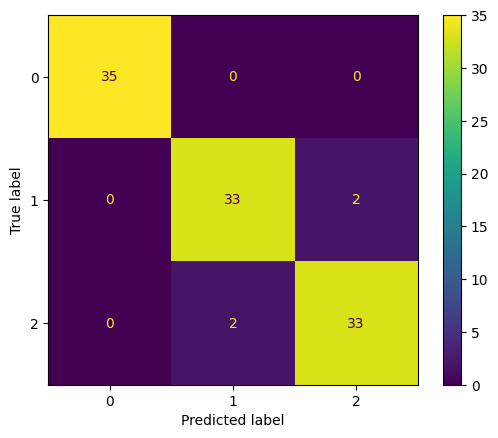

In [25]:
ConfusionMatrixDisplay.from_predictions(y_true=y_train, y_pred=svc_val_preds)
plt.show()

### Hyperparameter tuning

In [26]:
svc_tune_pipeline = make_pipeline(
    preprocessing,
    SVC(random_state=42, kernel='rbf', probability=True, decision_function_shape='ovo'))

In [27]:
# for i in svc_tune_pipeline.get_params().keys():
#     print(i)

In [28]:
svc_param_grid = [
    {
        "svc__kernel": ['rbf'],
        "svc__gamma": ['scale', 'auto'],
        "svc__C": [0.001, 0.01, 0.1, 1, 10]
    },
    {
        "svc__kernel": ['poly'],
        "svc__degree": [2,], # 3
        "svc__coef0": [1, 5, 10],
        "svc__gamma": ['scale'],
        "svc__C": [0.001, 0.01, 0.1]
    }
]

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
svc_gs = GridSearchCV(svc_tune_pipeline, svc_param_grid, cv=3, scoring='accuracy')
svc_gs.fit(X_train, y_train)
svc_gs.best_score_ # Best validataion score

0.980952380952381

In [31]:
pd.options.display.max_colwidth = 10
svc_gs_df = pd.DataFrame(svc_gs.cv_results_)
svc_gs_df.sort_values(by='mean_test_score', ascending=False, inplace=True)
svc_gs_df.drop(["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time", "params"], axis= "columns").head(10)

,param_svc__C,param_svc__gamma,param_svc__kernel,param_svc__coef0,param_svc__degree,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
18,0.1,scale,poly,10,2,0.971429,0.971429,1.000000,0.980952,0.013469,1
17,0.1,scale,poly,5,2,0.971429,0.971429,1.000000,0.980952,0.013469,1
8,10,scale,rbf,NaN,NaN,0.971429,0.942857,1.000000,0.971429,0.023328,3
9,10,auto,rbf,NaN,NaN,0.971429,0.942857,1.000000,0.971429,0.023328,3
6,1,scale,rbf,NaN,NaN,0.971429,0.942857,0.971429,0.961905,0.013469,5
7,1,auto,rbf,NaN,NaN,0.971429,0.942857,0.971429,0.961905,0.013469,5
16,0.1,scale,poly,1,2,0.971429,0.914286,0.885714,0.923810,0.035635,7
14,0.01,scale,poly,5,2,0.914286,0.885714,0.885714,0.895238,0.013469,8
15,0.01,scale,poly,10,2,0.914286,0.885714,0.885714,0.895238,0.013469,8
4,0.1,scale,rbf,NaN,NaN,0.914286,0.857143,0.857143,0.876190,0.026937,10


In [32]:
# Use the best params to get out of sample predictions on X_train

In [33]:
svc_gs.best_params_

{'svc__C': 0.1,
 'svc__coef0': 5,
 'svc__degree': 2,
 'svc__gamma': 'scale',
 'svc__kernel': 'poly'}

In [34]:
# Out of sample predictions
svc_tune_preds = cross_val_predict(svc_gs, X_train, y_train, cv=3)

In [35]:
print(classification_report(y_train, svc_tune_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.97      0.94      0.96        35
           2       0.94      0.97      0.96        35

    accuracy                           0.97       105
   macro avg       0.97      0.97      0.97       105
weighted avg       0.97      0.97      0.97       105



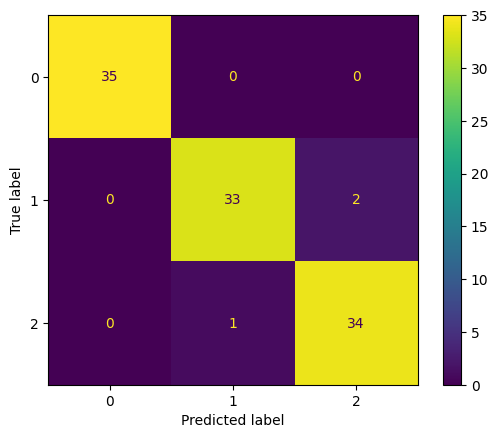

In [36]:
# plt.rc('font', size=9)  #  make the text smaller
ConfusionMatrixDisplay.from_predictions(y_true=y_train, y_pred=svc_tune_preds)
plt.show()

We got an imporoved validation score. and the standard deviation was slightly improved

# Get test set performance

In [37]:
svc_final_model = make_pipeline(
    StandardScaler(),
    SVC(C=0.1, coef0=5, degree=2,
        gamma="scale", kernel='poly', 
        random_state=42, decision_function_shape='ovo',
        probability=True))

svc_final_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=0.1, coef0=5, decision_function_shape='ovo', degree=2,
                     kernel='poly', probability=True, random_state=42))])

In [38]:
svc_test_preds = svc_final_model.predict(X_test)

In [39]:
print(classification_report(y_test, svc_test_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      0.93      0.93        15
           2       0.93      0.93      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



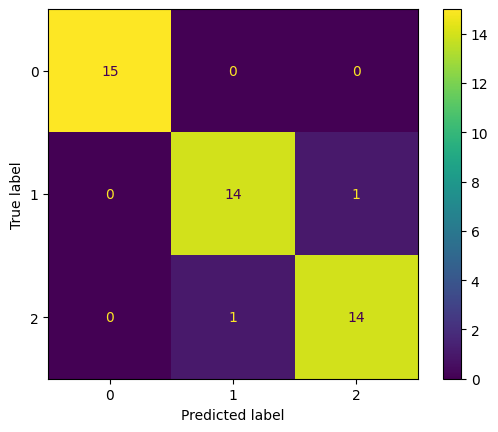

In [40]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=svc_test_preds)
plt.show()

96% accuracy

# Live Predictive analytics with Gradio

In [43]:
import numpy as np
import os
from PIL import Image

In [44]:
def make_prediction(sepal_length, sepal_width, petal_length, petal_width):
    sample = np.array([sepal_length, sepal_width, petal_length, petal_width]).reshape(1, 4)
    
    df = pd.DataFrame(
        sample, 
        columns=[
            'sepal_length', 'sepal_width', 
            'petal_length', 'petal_width'])

    pred = svc_final_model.predict(df)
    
    pred = ['setosa', 'versicolor', 'virginica'][pred[0]]

    predd = f"Iris {pred}"

    # Load and return image
    image_path = os.path.join('images', f'{pred}.jpg')
    image = Image.open(image_path)    

    return predd, image

In [45]:
t, p = make_prediction(7.3, 2.2, 4.3, 1.8)

In [48]:
# t

In [50]:
# p

In [51]:
import gradio as gr

In [52]:
demo = gr.Interface(
    fn=make_prediction, 
    inputs = [
        gr.Number(value=1.0, label="sepal length (cm)"),
        gr.Number(value=1.0, label="sepal width (cm)"),
        gr.Number(value=1.0, label="petal length (cm)"),
        gr.Number(value=1.0, label="petal width (cm)"),
    ],
    outputs=[
        gr.Text(),
        gr.Image(type='pil')
    ],
    title='Iris Flower Predictive analytics',
    description="Experiment with iris variables"
)

demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
